# Link Prediction on the Amazon Co-Purchase Graph with GNNs

## Data and Problem Statement - Overview

In this project, I want to explore the use of Graph Neural Networks (GNNs) to model structural relationships in a real-world. I use the Amazon product co-purchasing network and ground-truth communities data on the SNAP repository (link - https://snap.stanford.edu/data/com-Amazon.html)

A summary of the data:

- This data is based on the "Customers Who Bought This Item Also Bought" feature that we see on the Amazon website.
- Each node is an Amazon product. 
- An edge in this graph defines how often a product i has been co-purchased with product j - hence defining product-product relationships. 
- There is also the concept of a "community" for this graph, where each product's category provided in the Amazon catalog is a ground-truth community. Data at this level can also help us understand things that form at a community level.


The core task that I want to focus on is **link prediction**:

- Given two products, is there a way where we predict whether they should be connected in the co-purchase graph? 
- This is a classic problem in recommendation systems in e-commerce.
- A large part of this graph can be unseen product pairs. There might be a lot of products across these different categories / communities, indicating sparsity (as we will see). 
- This approach will allows us to evaluate how well structural graph patterns can guide suggestions for these unseen product pairs.


Modern recommendation systems focus heavily on how users interact with products in the catalog based on their view / add to cart / purchase patterns, and various other relevant signals that can be interpreted based on their activity on the e-commerce platform. By looking at product-product relationships through a graphical structure, we can gain underlying insights on questions like the following:

- Are there specific dominant products (or) communities of products that are linked? How are they connected and how similar are they?
- How expressive would node embeddings be by just considering the co-purchase context?
- How representative can this data / a model trained on this data be to power recommendation algorithms?


## Notebook Structure


1. **Exploring the Amazon co-purchase data**: Parse and visualize the Amazon co-purchase graph. Analyze statistics such as degree distributions, component sizes, clustering, and community structure.
3. **Task Framing**: Define the link prediction task as a binary classification problem.
4. **Model Development**: Train a GNN to learn node embeddings and use a scoring function to predict links.
5. **Evaluation & Insights**: Measure model performance and interpret results both quantitatively and qualitatively.

# Imports

In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from collections import Counter
from pprint import pprint

# Exploring the Amazon co-purchase dataset

### Loading the graph data & summarizing basic overall graph statistics


- Let us try to understand the structural properties of our co-purchase graph - to get an idea of how densely the products are connected and whether any global patterns emerge.

- Below, we compute and summarize basic statistics of the graph, including the number of nodes and edges, average degree, graph density, clustering coefficient, and details about connectivity. 

<!-- These statistics not only help validate data quality but also guide how we construct models—for instance, sparse graphs with strong clustering may benefit from localized message passing in GNNs. -->

<!-- The **largest connected component** is particularly important, as GNNs rely on connectivity for message propagation. We'll focus our modeling efforts on this component to ensure meaningful learning. -->


In [2]:
def load_graph(file_path):
    edges = []
    with gzip.open(file_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return nx.Graph(edges)

def basic_graph_stats(G):

    number_of_nodes = G.number_of_nodes()
    number_of_edges = G.number_of_edges()
    degrees = dict(G.degree()).values()

    stats = {
        "Number of nodes": number_of_nodes,
        "Number of edges": number_of_edges,
        "Average degree": sum(degrees) / number_of_nodes if number_of_nodes > 0 else 0,
        "Density": nx.density(G),
        "Average clustering coefficient": nx.average_clustering(G),
        "Number of connected components": nx.number_connected_components(G),
        "Size of largest component": len(max(nx.connected_components(G), key=len)) if number_of_nodes > 0 else 0,
    }
    return stats

In [3]:
graph = load_graph(file_path="data/raw/com-amazon.ungraph.txt.gz")
print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

stats = basic_graph_stats(graph)
print("\n\n\n*** OVERALL GRAPH STATISTICS ***\n")
print(json.dumps(stats, indent=4))

Graph has 334863 nodes and 925872 edges.



*** OVERALL GRAPH STATISTICS ***

{
    "Number of nodes": 334863,
    "Number of edges": 925872,
    "Average degree": 5.529855493141971,
    "Density": 1.6513834036534368e-05,
    "Average clustering coefficient": 0.3967463932787655,
    "Number of connected components": 1,
    "Size of largest component": 334863
}


#### High-level Insights:


- The statistics suggests that each product is co-purchased with 5–6 others on average, which is low in comparison to the overall number of products, and is typical purchase pattern in such platforms. 

- These 5-6 products that are linked are either similar category or something that complements each other. 

    - For example, {phone, phone-case, screen-protector} (or) {PS5, additional controller, charger for controllers} might be purchased together as they are contextually related and purchasing them together enhances the usability of the phone or the PS5. 
    - Another example could be {shampoo, conditioner, hair wax} - all same category and can be likely purchased together because someone wants to invest in hair products.

- The graph is **extremely sparse** - a major chunk of products are not linked, as it should be.

    - Links only exist for contextually similar or categorically similar products as seen above. 
    - The whole category has over 300k products and not every product is contextually related.

- The average clustering coefficient of this graph is around ~0.4 and this is quite high for such a sparse graph. 

    - This means that there are some strong local communities.
    - If a product A is co-purchased with B and C, then B and C are also very likely co-purchased with each other.

- The graph is fully connected - there is a path that connects each product to every other via some sequence of co-purchases.

These statistics confirm that the Amazon co-purchase graph exhibits **small-world properties** -  high local clustering and global connectivity (one connected component despite sparsity).


### Community graph - High level Insights:

- Each “community” in the dataset is defined as a connected component within a specific product category. 

- These groups reflect semantically coherent product clusters — such as books, electronics, or clothing — where intra-community interactions (e.g., co-purchases) are dense and meaningful.

In [4]:
filepath = "data/raw/com-amazon.all.dedup.cmty.txt.gz"
all_cmty_nodes = set()
with gzip.open(filepath, 'rt') as f:
    line_count = sum(1 for _ in f)

print(f"Total communities in file: {line_count}")

with gzip.open(filepath, 'rt') as f:
    for i in range(10):
        line = f.readline()
        print(f"Line {i}: '{line.strip()}'")

Total communities in file: 75149
Line 0: '100005	127545	202036	257630	362970	376927	429080'
Line 1: '10001	27638	51569	88226	116422	126227	159947	162938	184977	188045	191044	246142	265214	290507	296858	300258	341525	348922	359832	365744	382502	390538	410857	433453	479170	489980	540746'
Line 2: '10001	27638	51569	88226	116422	126227	159947	162938	184977	188045	191044	246142	265214	290507	300258	341525	348922	359832	365744	382502	390538	410857	433453	479170	489980	540746'
Line 3: '100017	118111	263647	268405	315862'
Line 4: '100020	267700	301658	376628	410518	464375'
Line 5: '100022	298856	412978	472429'
Line 6: '100025	179592	260929	464366'
Line 7: '100025	260929	328722	411257'
Line 8: '100025	286364	301821	316953	421421	467329	488266	491602	519950'
Line 9: '100030	106036	209079	289843'


In [5]:
filepath = "data/raw/com-amazon.top5000.cmty.txt.gz"
all_cmty_nodes = set()
with gzip.open(filepath, 'rt') as f:
    line_count = sum(1 for _ in f)

print(f"Total communities in file: {line_count}")

with gzip.open(filepath, 'rt') as f:
    for i in range(10):
        line = f.readline()
        print(f"Line {i}: '{line.strip()}'")

Total communities in file: 5000
Line 0: '164985	225214	232761'
Line 1: '105089	282815	331787'
Line 2: '167906	288975	421279	442612	451312'
Line 3: '69880	231953	518997	523128'
Line 4: '135499	160294	304770'
Line 5: '112813	112814	112821	112823'
Line 6: '112813	112814	112821	112823'
Line 7: '199372	399560	447268	471226	522928'
Line 8: '179001	391697	412528'
Line 9: '21166	207188	405926	531532	540207'


In [6]:
def extract_top_communities_subgraph(G, community_path):
    community_map = {}
    community_id = 0

    with gzip.open(community_path, 'rt') as f:
        for line in f:
            nodes = list(map(int, line.strip().split('\t')))
            for node in nodes:
                if node in G and node not in community_map:
                    community_map[node] = community_id
            community_id += 1

    selected_nodes = set(community_map.keys())
    G_sub = G.subgraph(selected_nodes).copy()

    return G_sub, community_map


In [7]:
_, entire_community_map = extract_top_communities_subgraph(
    graph, community_path="data/raw/com-amazon.all.dedup.cmty.txt.gz"
)


top_k_community_graph, top_k_community_map = extract_top_communities_subgraph(
    graph, community_path="data/raw/com-amazon.top5000.cmty.txt.gz"
)
print(f"Top-5000 community subgraph has {top_k_community_graph.number_of_nodes()} nodes and {top_k_community_graph.number_of_edges()} edges.")

top_k_community_stats = basic_graph_stats(top_k_community_graph)
print("\n\n\n*** TOP-K COMMUNITY GRAPH STATISTICS ***\n")
print(json.dumps(top_k_community_stats, indent=4))

Top-5000 community subgraph has 16716 nodes and 48739 edges.



*** TOP-K COMMUNITY GRAPH STATISTICS ***

{
    "Number of nodes": 16716,
    "Number of edges": 48739,
    "Average degree": 5.831418999760708,
    "Density": 0.00034887340710503786,
    "Average clustering coefficient": 0.6488186833732773,
    "Number of connected components": 1106,
    "Size of largest component": 475
}


- The top-5000 community subgraph retains similar local structural properties - statistics such as average degree and clustering behavior is the same

-  The difference is visible in the global structure - the subgraph is far denser and highly fragmented as there are many disconnected components. 

- Each top community is very densely connected internally but poorly connected externally, which was something that we observed in the overall graph.

- If we only consider products that only belong to top-5000 communities, then we are not considering edges that go from the top-5000 communities to other products that are not part of the top-5000 communities. Those bridge edges are lost here.

- Let us try to include the bridge edges for all the nodes and analyse again.

In [8]:
# Rewriting this function
def extract_top_communities_subgraph(G, community_path):
    import gzip

    community_map = {}
    community_id = 0

    # Read top-k communities and build the node set
    with gzip.open(community_path, 'rt') as f:
        for line in f:
            nodes = list(map(int, line.strip().split('\t')))
            for node in nodes:
                if node in G and node not in community_map:
                    community_map[node] = community_id
            community_id += 1

    top_k_nodes = set(community_map.keys())

    # Include all edges where at least one node is in top-k
    expanded_edges = [(u, v) for u, v in G.edges() if u in top_k_nodes or v in top_k_nodes]

    # Build the new graph
    G_expanded = nx.Graph()
    G_expanded.add_edges_from(expanded_edges)

    return G_expanded, community_map


In [9]:
top_k_community_expanded_graph, top_k_community_expanded_map = extract_top_communities_subgraph(graph, "data/raw/com-amazon.top5000.cmty.txt.gz")

print(f"Top-5000 expanded subgraph has {top_k_community_expanded_graph.number_of_nodes()} nodes and {top_k_community_expanded_graph.number_of_edges()} edges")

top_k_community_expanded_stats = basic_graph_stats(top_k_community_expanded_graph)
print("\n\n\n*** TOP-K COMMUNITY EXPANDED GRAPH STATISTICS ***\n")
print(json.dumps(top_k_community_expanded_stats, indent=4))

Top-5000 expanded subgraph has 19905 nodes and 53780 edges



*** TOP-K COMMUNITY EXPANDED GRAPH STATISTICS ***

{
    "Number of nodes": 19905,
    "Number of edges": 53780,
    "Average degree": 5.403667420246169,
    "Density": 0.0002714865062422714,
    "Average clustering coefficient": 0.5384229737133063,
    "Number of connected components": 1044,
    "Size of largest component": 481
}


| Metric                 | Top-5000 Only | Expanded Version     | Interpretation                                               |
| ---------------------- | ------------- | -------------------- | ------------------------------------------------------------ |
| Nodes                  | 16,716        | 19,905               | +3.2k bridge nodes added                                     |
| Edges                  | 48,739        | 53,780               | \~5k new edges, mostly community-to-outside                  |
| Avg. Degree            | 5.83          | 5.40                 | Slight drop, expected since bridges dilute dense intra-links |
| Density                | 0.00035       | 0.00027              | Slightly lower — again expected due to bridge sparsity       |
| Avg. Clustering Coeff. | 0.65          | 0.54                 | Drop shows that bridge nodes are less clustered              |
| Connected Components   | 1106          | 1044                 | Slight improvement in connectivity                           |
| Largest Component Size | 475           | 481                  | Marginal increase                                            |

- There are around ~5k new edges added and all of these are bridge edges, which add important context of co-purchasing patterns.

- The average degree distribution is still consistent, and the clustering coefficient slightly drops and is now closer to the distributions in the overall graph.

- Fragmentation has slightly reduced because of the introduction to the bridge edges.


We can use the expanded version of the top_k community graph because:

- The average clustering coefficient in this subset is 0.54, much higher than the full graph (0.39), indicating stronger local cohesion

- Though this subset includes only ~5% of all nodes, it captures a significant portion of useful interaction patterns due to high internal density.

- Hence we can constrain the problem to **predict future or missing co-purchase links between products within and near top-5000 communities**.

- Here, **near** comes from past interactions (we included some links from top_k to non-top_k nodes)


### Structural Analysis

- Analyzing community structure helps reveal more information about graph relationships. 

- It can convey information about how consumers navigate the catalog, whether they buy within or across contexts and categories, and what kind of structural patterns govern co-purchases.

In [10]:
def degree_distribution_plot(G):
    degrees = [d for n, d in G.degree()]
    plt.hist(degrees, bins=100, log=True)
    plt.xlabel("Node Degree")
    plt.ylabel("Frequency (log)")
    plt.title("Degree Distribution")

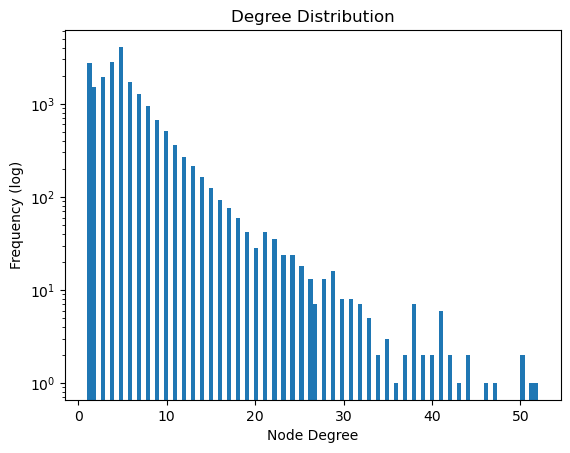

In [11]:
degree_distribution_plot(top_k_community_expanded_graph)

- The degree distribution follows a **long-tail pattern** - consistent with a power-law or **scale-free network**. Most nodes have low degree (1–5), while a few nodes are high-degree hubs with 30+ connections.

- The log-scale frequency confirms that a small number of products dominate the co-purchase network.

In [12]:
def size_density_plot(G, community_map):

    density_by_comm = {}
    for cid in set(community_map.values()):
        nodes = [n for n, c in community_map.items() if c == cid]
        subg = G.subgraph(nodes)
        density_by_comm[cid] = nx.density(subg)

    # Plot size vs. density
    import matplotlib.pyplot as plt

    sizes = [len([n for n in community_map if community_map[n] == cid]) for cid in density_by_comm]
    densities = list(density_by_comm.values())

    plt.scatter(sizes, densities, alpha=0.5)
    plt.xlabel("Community Size")
    plt.ylabel("Internal Edge Density")
    plt.title("Community Size vs Density")


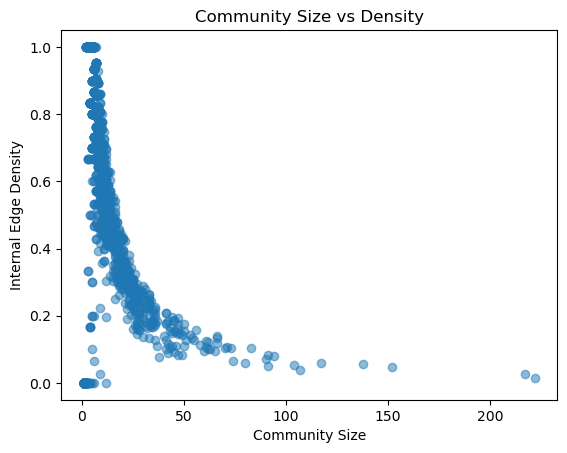

In [13]:
size_density_plot(top_k_community_expanded_graph, top_k_community_expanded_map)

In [14]:
def community_size_distribution_plot(community_map):
    community_sizes = Counter(community_map.values())
    sns.histplot(list(community_sizes.values()), bins=50)

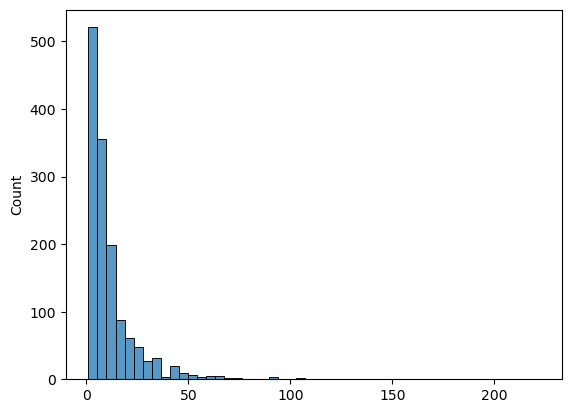

In [15]:
community_size_distribution_plot(top_k_community_expanded_map)

- There is a inverse relationship between community size and internal edge density. Small communities (≤ 20 nodes) often have very high densities, which likely represent tightly interconnected product bundles.

- As community size increases, density rapidly drops, indicating that larger communities are more diffuse and possibly span multiple subcategories or product types.

- This shows that small, niche categories are highly cohesive, possibly representing co-purchase sets.

In [16]:
def bridge_ratio_plot(G, community_map):

    bridge_ratios = {}
    for cid in set(community_map.values()):
        comm_nodes = set(n for n, c in community_map.items() if c == cid)
        internal_edges = 0
        bridge_edges = 0
        for node in comm_nodes:
            for neighbor in G.neighbors(node):
                if neighbor in comm_nodes:
                    internal_edges += 1
                else:
                    bridge_edges += 1
        total_edges = internal_edges + bridge_edges
        bridge_ratios[cid] = bridge_edges / total_edges if total_edges > 0 else 0

    # Histogram of bridge ratios
    plt.hist(list(bridge_ratios.values()), bins=20, edgecolor='black')
    plt.xlabel("Bridge Ratio")
    plt.ylabel("Frequency")
    plt.title("Bridge Ratio Distribution")
    plt.show()

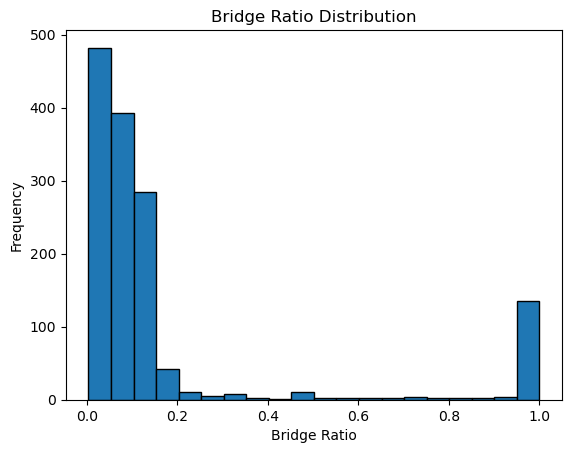

In [17]:
bridge_ratio_plot(top_k_community_expanded_graph, top_k_community_expanded_map)

- The majority of communities have low bridge ratios (< 0.2), indicating that most edges are internal. We could see this when expanding only gave 5k more edges.

- A few have a bridge ratio close to 1, meaning nearly all edges connect to other communities.